In [1]:
import json
import numpy as np
import random
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from IPython.display import Audio
from itertools import islice
from pathlib import Path
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import get_window
import librosa
import librosa.display

In [2]:
plt.rcParams['figure.figsize'] = (12, 3)

# Задача 1: Построение модели распознавания речи.

Алгоритм распознавания речи состоит из следующих этапов:
- Этап предварительной обработки, который преобразует необработанный звук в представление признаков, которое обычно используются для ASR (Automatic Speech Recognition);
- Этап создания акустической модели, которая принимает аудио признаки в качестве входных данных и возвращает распределение вероятностей по всем потенциальным транскрипциям;
- Этап принятия выходных данных из акустической модели и возвращения предсказанной транскрипции.

In [3]:
# Вы можете загрузить свой аудиофайл и файлы с текстовым описанием

AUDIO = '/Users/Protector/Sounds/8a7aa386717c.mp3'
CSV = 'C:/Users/Protector/Sounds/example.csv'

In [4]:
# открываем аудиофайл
clip, sample_rate = librosa.load(AUDIO, sr=None)

C:\Users\Protector\AppData\Roaming\Python\Python37\site-packages\librosa\core\audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [5]:
print('Частота дискретизации   {} Гц'.format(sample_rate))
print('Длина аудиофайла   {:3.2f} секунд'.format(len(clip)/sample_rate))

Частота дискретизации   16000 Гц
Длина аудиофайла   0.34 секунд


Первый график ниже отображает весь сигнал полностью

Второй график уже увеличивает какой-то частотный диапозон, где мы можем наблюдать какую амплитудуимеет каждый объект
из массива clip (данный массив представлен в виде временненого ряда), который представлен в виде одномерного массива типа NumPy с плавающей точкой NumPy

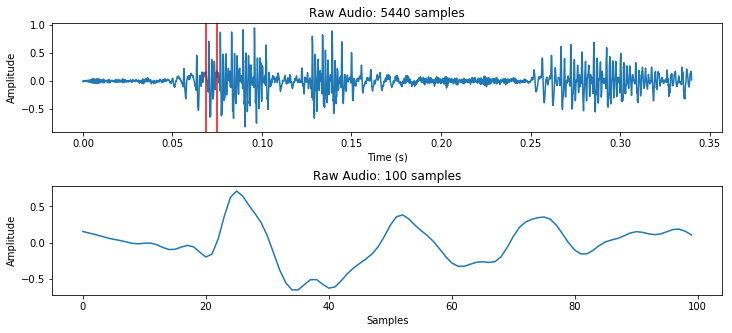

In [6]:
timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5)

# изобразить всю запись
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} samples'.format(len(clip)))


n_fft = 100 # длина кадра
start = 1100 # начать с какой-то части записи 
x = clip[start:start+n_fft]

ax[0].axvline(start/sample_rate, c='r') 
ax[0].axvline((start+n_fft)/sample_rate, c='r')
 
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio: {} samples'.format(len(x)));

## Признаковое описание сигнала

Существует два основных способа представления сигнала в виде признакового описания. Спектрограмма – изображение, показывающее зависимость спектральной плотности мощности сигнала от времени. MFCC (Мел-частотные кепстральные коэффициенты). Основная идея MFCC аналогична спектрограммам: в каждом временном окне MFCC выдает вектор признаков, который характеризует звук внутри окна. Стоит обратить внимание, что признаки, полученные с помощью MFCC, имеют намного меньшую размерность, чем признаки, полученные с помощью спектрограмм. Это поможет нашей модели не переобучиться на тренировочном датасете. 

Далле в своей работе я буду использовать MFCC

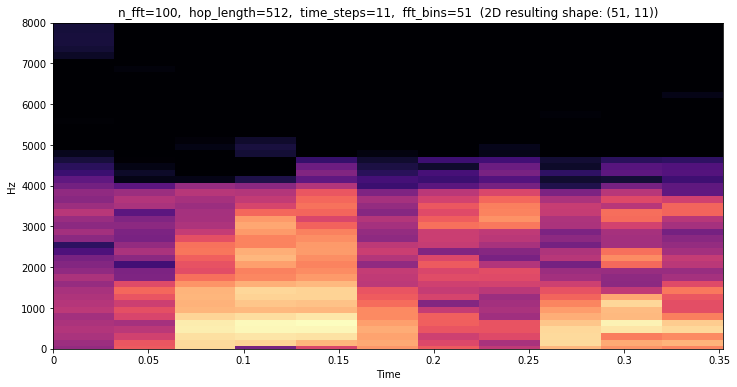

In [7]:
# Использование Short-Term Fourier Transform

hop_length = 512
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

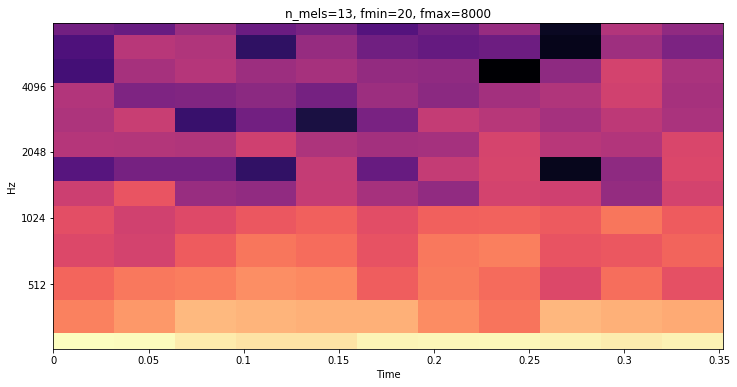

In [8]:
# Использование mel-спектограмм (MFCC)
n_mels = 13

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.mfcc(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax)

title = 'n_mels=13, fmin=20, fmax=8000'
plt.title('n_mels=13, fmin=20, fmax=8000');

plt.show()

Теперь подготовим нашу акустическую модель

In [18]:
import tensorflow.compat.v1 as tf 
import tensorflow.compat.v1.keras
from keras.backend.tensorflow_backend import set_session
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Lambda)


gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
set_session(session)

Using TensorFlow backend.


In [19]:
import wave
import _pickle as pickle

Необходимо определить два словаря для преобразований между текстовыми и целочисленными последовательностями

In [20]:
char_map_str = """
<SPACE> 0
а 1
б 2
в 3
г 4
д 5
е 6
ё 7
ж 8
з 9
и 10
й 11
к 12
л 13
м 14
н 15
о 16
п 17
р 18
с 19
т 20
у 21
ф 22
х 23
ц 24
ч 25
ш 26
щ 27
ъ 28
ы 29
ь 30
э 31
ю 32
я 33
0 34
1 35
2 36
3 37
4 38
5 39
6 40
7 41
8 42
9 43
№ 44
s 45
a 46
p 47
e 48
w 49
o 50
d 51
v 52
m 53
- 54

"""

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[1] = ' '

In [21]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

## Выбор модели нейронной сети

Далее необходимо было выбрать архитектуру нейронной сети. Очевидно, что для решения задачи распознавания речи нужно 
использовать RNN слои. На каждом временном шаге один из 33 букв русского алфавита и возможно пару английских букв. 
Также стоит учитывать пробел и дефис. Выход RNN слоя на каждом временном шаге представляет собой 
вектор вероятностей с каким-то количеством вхождений, которое можно задать. В данном векторе i-ая запись кодирует вероятность 
того, что i-ый символ произнес во временной последовательности (дополнительный пустой символ или пробел используется, 
чтобы дополнять тренировочные примеры в батчях, содержащих неравную длину).

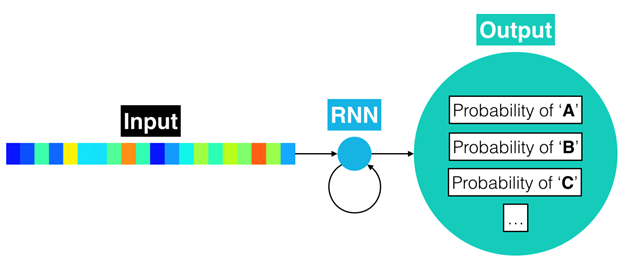

Однако обычные RNN слои малоэффективные, поэтому лучше использовать LSTM или GRU слои. LSTM слои имеют более продвинутый 
и более сложный способ вычисления. Данный способ, помимо входных значений и предыдущего состояния сети, использует также 
фильтры (gates), которые определяют каким образом информация будет использоваться для вычисления как входных значений на 
текущем слое, так и значений скрытого слоя на следующем шаге. Модель GRU основана на тех же принципах, но использует меньше 
фильтров и операций для вычисления итогового значения 

В своей работе и использую LSTM слои, так как они показывают лучшую точность и меньшее значение функции потерь.

Однако просто слоёв LSTM недостаточно. Точность модели все равно крайне низкая. Чтобы улучшить точность необходимо добавить слои TimeDistributed, необходимый для поиска более сложных паттернов в наборе данных, и  BatchNormalization, необходимый чтобы сократить время обучения. Далее стоит усложнить архитектуру, а именно добавить слой 1D convolution.

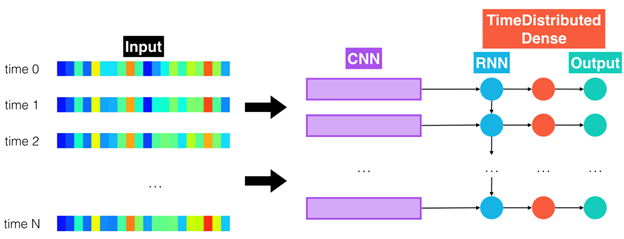

Если говорить об итоговой архитектуре, которую я использовал то это двухслойная LSTM сеть плюс сверточный слой вначале.
Причина, по которой данная архитектура показывает лучшие результаты это то, что  сверточный слой отлично выбирает важные 
признаки из звукового представления сигнала в виде MFCC, а затем уже передает эти признаки в LSTM сеть. 
Значения функции потерь составили примерно 150 – 200.

In [22]:
input_data = Input(name='the_input', shape=(None, 13))

In [1]:
conv_1d = Conv1D(200, 11, strides=2, padding='valid', activation='tanh',
                 name='conv1d', dilation_rate=1)(input_data)
bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)
simp_rnn = LSTM(250, activation='tanh', return_sequences=True, implementation=2, name='rnn_1', dropout=0.9)(bn_cnn)
bn_rnn = BatchNormalization(name='bn_rnn_1')(simp_rnn)
simp_rnn_fin = LSTM(250, activation='tanh', return_sequences=True, implementation=2, name='final_layer_of_rnn', dropout=0.9)(bn_rnn)
bn_rnn_fin = BatchNormalization(name='bt_rnn_final')(simp_rnn_fin)
time_dense = TimeDistributed(Dense(56))(bn_rnn_fin)
y_pred = Activation('softmax', name='softmax')(time_dense)

NameError: name 'Conv1D' is not defined

In [24]:
model = Model(inputs=input_data, outputs=y_pred)
model.output_length = lambda x: cnn_output_length(x, 11, 'valid', 2)

In [25]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn_1 (LSTM)                 (None, None, 250)         451000    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 250)         1000      
_________________________________________________________________
final_layer_of_rnn (LSTM)    (None, None, 250)         501000    
_________________________________________________________________
bt_rnn_final (BatchNormaliza (None, None, 250)         1000  

Теперь поговорим о настройке дополнительных параметрах в данной сети. К слоям LSTM я добавил dropout, равный 0.9. На самом деле сильно он не повлиял на точность, однако всё-таки улучшил её. Dropout - это популярная методика регуляризации с глубокими сетями, где некоторые случайные нейроны не принимают участия в обучение (отбрасываются). Также для улучшения точности модели можно использовать расширенные сверкти (dilated convolutions). Расширенная свертка - это свертка, в которой фильтр применяется к области, превышающей его длину, путем пропуска входных значений с определенным шагом. Это эквивалентно свертке с более крупным фильтром, полученным из исходного фильтра путем расширения его нулями, но значительно более эффективно. Расширенная свертка позволяет сети работать в более широком масштабе, чем при обычной свертке. Это похоже на объединение или пошаговые свертки, но здесь выход имеет тот же размер, что и вход. В своей работе я выставил значение равным единице. Количество эпох было выбрано равным 20. Количество выходных фильтров в CNN слое равно 400. Число, указывающее длину окна свертки равно 11. Размерность выходного пространства для LSTM слоев равно 250. Функцию активации, которую я использовал, была гиперболический тангенс. Её природа нелинейна, она хорошо подходит для комбинации слоёв, а диапазон значений функции - (-1, 1). Она была выбрана, так как в ходе обучения возникала проблема взрывающего градиента, когда градиент принимает слишком большие значения и становится nan. Для данной функции нет смысла беспокоиться, что она перегрузится от больших значений.

In [26]:
from tensorflow.compat.v1.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.compat.v1.keras.callbacks import ModelCheckpoint   
import os
from python_speech_features import mfcc

In [27]:
def text_to_int_sequence(text):
    # Преобразовать текст в целочисленную последовательность
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    # Преобразовать целочисленную последовательность в текст
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text

In [59]:
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

In [60]:
# класс для работы с аудиофайлами

class AudioReceive():
    def __init__(self, step=10, window=10, max_freq=8000, mfcc_dim=13,
                minibatch_size=20, desc_file=None, max_duration=20.0):
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(123)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        #self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size

    def get_batch(self, partition):
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in audio_paths[cur_index:cur_index+self.minibatch_size]]

        # рассчитываем необходимые размеры
        max_length = max([features[i].shape[0] for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) for i in range(0, self.minibatch_size)])

        # инициализируем массивы
        X_data = np.zeros([self.minibatch_size, max_length, self.mfcc_dim])
        labels = np.ones([self.minibatch_size, max_string_length]) * 55
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])

        for i in range(0, self.minibatch_size):
            # считаем X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # считаем labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)

        # возвращаем массивы
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                      'the_labels': labels, 
                      'input_length': input_length, 
                      'label_length': label_length 
                     }

        return (inputs, outputs)  

    def shuffle_data_by_partition(self, partition):
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. Must be train/validation")
            
            
    def next_train(self):
        # Получаем батч тренировочных данных
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                #self.shuffle_data_by_partition('train')
            yield ret 
            
    def next_valid(self):
        # Получаем батч валидационных данных
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                #self.shuffle_data_by_partition('valid')
            yield ret
             
    def next_test(self):
       # Получаем батч тестовых данных
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret
            
            
    def load_train_data(self, desc_file='train.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()

    def load_validation_data(self, desc_file='valid.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')

    def load_test_data(self, desc_file='test.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
        
    def load_metadata_from_desc_file(self, desc_file, partition):
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    #if float(spec['duration']) > self.max_duration:
                    #    continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    print('Error reading line #{}: {}'.format(line_num, json_line))

        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. Must be train/validation/test")
            
    def fit_train(self, k_samples=20):
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
     
    def featurize(self, audio_clip):
        (rate, sig) = wav.read(audio_clip)
        return mfcc(sig, rate, numcep=self.mfcc_dim, nfft = 1103)
    
    def normalize(self, feature, eps=1e-14):
        return (feature - self.feats_mean) / (self.feats_std + eps)

In [35]:
def shuffle_data(audio_paths, durations, texts):
        """ Перемешать данные (вызывается после полного прохождения 
            training или validation данных в течении процесса обучения)
        Params:
            audio_paths (list): Пути к аудиофайлам
            durations (list): Продолжительность высказываний для каждого аудиоклипа
            texts (list): Предложения, произнесенные в каждом аудиофайле
        """
        p = np.random.permutation(len(audio_paths))
        audio_paths = [audio_paths[i] for i in p] 
        durations = [durations[i] for i in p] 
        texts = [texts[i] for i in p]
        return audio_paths, durations, texts

Немного нужно рассказать про функцию потерь, которую я использовал. Эта функция потерь называется CTC (Connectionist Temporal Classification). Важные преимущества данной функции потерь заключается в том, что происходит устранение необходимости определять неоднозначные границы меток (например, в речи или рукописном вводе) и есть возможность группировать прогнозы меток, если это оказывается полезным (например, если несколько меток обычно встречаются вместе).

In [29]:
# Функция потерь CTC

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # output_length = BatchNormalization()(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model

In [30]:
def train_model(model, 
                pickle_path,
                save_model_path,
                train_json='train.json',
                valid_json='valid.json',
                minibatch_size=20,
                mfcc_dim=13,
                #optimizer=SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                optimizer=Adam(lr=0.03, beta_1=0.9, beta_2=0.999, amsgrad=True),
                epochs=20,
                verbose=1,
                max_duration=20.0):
    
    audio_rec = AudioReceive(minibatch_size=minibatch_size, mfcc_dim=mfcc_dim, max_duration=max_duration)
    audio_rec.load_train_data(train_json)
    audio_rec.load_validation_data(valid_json)

    #считаем шаги за эпоху
    num_train_examples=len(audio_rec.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    num_valid_samples = len(audio_rec.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    model1 = add_ctc_loss(model)
    model1.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    
    if not os.path.exists('results'):
        os.makedirs('results')
        
    checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)
    
    #тренируем моедль
    hist = model1.fit_generator(generator=audio_rec.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_rec.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose)
    
    # сохраняем потери модели
    with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)

In [113]:
# не обращайте внимание на ошибку
# просто по окончанию тренировки забыл установить модуль Pickle, который создаст файл для хранения значения потерь

train_model(model=model, 
            pickle_path='model.pickle', 
            save_model_path='model.h5') 

Epoch 1/20
12/12 [==============================] - 256s 21s/step - loss: 374.5694 - val_loss: 357.6669
Epoch 2/20
12/12 [==============================] - 254s 21s/step - loss: 304.0705 - val_loss: 326.5615
Epoch 3/20
12/12 [==============================] - 245s 20s/step - loss: 274.4922 - val_loss: 271.9562
Epoch 4/20
12/12 [==============================] - 243s 20s/step - loss: 251.3850 - val_loss: 276.1869
Epoch 5/20
12/12 [==============================] - 248s 21s/step - loss: 247.2293 - val_loss: 266.6015
Epoch 6/20
12/12 [==============================] - 245s 20s/step - loss: 243.9274 - val_loss: 265.8563
Epoch 7/20
12/12 [==============================] - 250s 21s/step - loss: 242.3600 - val_loss: 265.2929
Epoch 8/20
12/12 [==============================] - 251s 21s/step - loss: 243.1519 - val_loss: 266.1812
Epoch 9/20
12/12 [==============================] - 252s 21s/step - loss: 242.7371 - val_loss: 266.9386
Epoch 10/20
12/12 [==============================] - 254s 21s/st

NameError: name 'pickle' is not defined

In [1]:
#Данная ошибка пока считается более менее приемлемой так как изначально она достигала значений около 3000.
#На выходе получались достаточно запутанные фразы или "ничего". Но мы планиурем продолжить обучать данную модель.

Использованная мной метрика для измерения качества была WER (Коэффициент ошибок в словах). Данная метрика является общей для измерения производительности системы распознавания речи или машинного перевода.

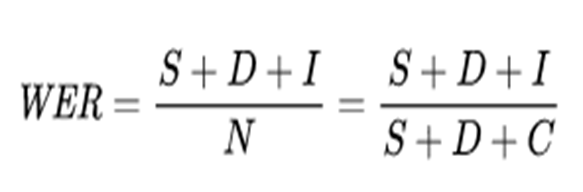

В данной формуле:
- S – число замен;
- D – число удалений;
- I – число вставок;
- N – общее число слов в оригинальной фразе;
- C – количество правильных слов.

In [2]:
def wer(r, h):
    """
    Расчет WER, используя расстояние Левенштейна.

    Параметры
    ----------
    r : list
    h : list

    Returns
    -------
    int

    """
    # инициализация
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # вычисление
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

In [5]:
wer("Не удалось обновить акт".split(), "Не удалось обновить акт".split())

0

In [8]:
# Вот такие приблизительно фразы могли получаться в ходе тренировки (чаще даже хуже)
# "Ен тка обновить удалось что сделать нжн"
# Нужно будет больше тренировать модель и дорабатывать архитектуру.
wer("нет роли мол".split(), "нет роли мол".split())

2

В моей работе точность по данной метрике вариьровалась от 5 до 15. Предсказанные транскрипции, которые возвращала моя модель были такими же как можете видеть выше справа (были варианты и хуже).
Разумеется если дольше обучать модель и улучшать архитектуру, то можно прийти к лучшему результату.